# Thereshold Test for NWDI Calculations 

In [1]:
%matplotlib notebook
import os
import rasterio 
import numpy as np
import numpy.ma as ma
#import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
#from shapely.geometry import box
#from fiona.crs import from_epsg
#from rasterio.mask import mask
plt.rcParams['figure.figsize'] = 10, 5

In [3]:
os.chdir('./NDWI_Func/')
from Mask_generator import interection
from Harold_Moltke_thres_walk import NDWI_calc, NDWI_npmask
os.chdir('..')

Need to test the difference between the NDWI and MNWDI for water detection. Then need to determine the best threshold. Although this will be very tricky since "best" is really conditional upon lots of envrionmental conditions on the surface.

## Harold Moltke

In [ ]:
hm_dir = '/Users/glaciologygroup/Greenland_Calving/Landsat_NDWI/thresh_test/LC08_L1TP_031005_20180825_20180829_01_T1/'
GIMP_tile = '/Users/glaciologygroup/Greenland_Calving/Landsat_NDWI/GIMP_masks/GimpIceMask_30m_tile0_4_v1.1_PS.tif'

Get the file paths of the selected bands 

In [ ]:
bands = os.listdir(hm_dir)
for i,band in enumerate(bands):
    if band.endswith('B3_30PS.TIF') == True:
        hm_g_fn = hm_dir + '/' + bands[i]
    elif band.endswith('B5_30PS.TIF') == True:
        hm_nit_fn = hm_dir + '/' + bands[i]
    elif band.endswith('B6_30PS.TIF') == True:
        hm_swir_fn = hm_dir + '/' + bands[i]

Finds the intersection of the Landsat Scenes and the GIMP masks, then reads in the selected rasters based on the determined overlap

In [ ]:
hm_interesction = interection(hm_g_fn, GIMP_tile)
with rasterio.open(hm_g_fn) as src:
    sub_window = src.window(*hm_interesction, precision = 15)
    hm_g_bounds = src.bounds
    hm_g = src.read(1, window = sub_window)

with rasterio.open(hm_nit_fn) as src:
    sub_window = src.window(*hm_interesction, precision = 15)
    hm_nir= src.read(1, window = (sub_window))
    
with rasterio.open(hm_swir_fn) as src:
    sub_window = src.window(*hm_interesction, precision = 15)
    hm_swnir= src.read(1, window = (sub_window))

with rasterio.open(GIMP_tile) as src:
    sub_window = src.window(*hm_interesction, precision = 15)
    hm_GIMP_bounds = src.bounds
    hm_gimp_trans = src.transform
    GIMP_mask = src.read(1, window = sub_window)

Create numpy masked arrays based on the GIMP land classification masks 

In [ ]:
hm_g_m = ma.array(hm_g[:GIMP_mask.shape[0],:GIMP_mask.shape[1]], mask = (GIMP_mask == 0), dtype =np.float64)
hm_g_m = ma.array(hm_g_m, mask = (1 >= hm_g_m), dtype =np.float64)

hm_nir_m = ma.array(hm_nir[:GIMP_mask.shape[0],:GIMP_mask.shape[1]], mask = (GIMP_mask == 0), dtype =np.float64)
hm_nir_m = ma.array(hm_nir_m, mask = (1 >= hm_nir_m), dtype =np.float64)

hm_swnir_m = ma.array(hm_swnir[:GIMP_mask.shape[0],:GIMP_mask.shape[1]], mask = (GIMP_mask == 0), dtype =np.float64)
hm_swnir_m = ma.array(hm_swnir_m, mask = (1 >= hm_swnir_m), dtype =np.float64)

In [ ]:
hm_ndwi = NDWI_calc(hm_g_m, hm_nir_m)
hm_mndwi = NDWI_calc(hm_g_m, hm_swnir_m)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.imshow(hm_ndwi, clim = (-1, 1), cmap = 'seismic')
ax1.imshow(hm_mndwi, clim= (-1, 1), cmap = 'seismic')

create a smaller zoom window that is 4.98 km^2 (not exactly 5 km^2 in order to prevent partial pixels)

In [ ]:
# xmin, ymin, xmax, ymax
HM_zoom = [3337,7350, 3337+166, 7350+166]
hm_ndwi_zoom = hm_ndwi[HM_zoom[1]:HM_zoom[3],HM_zoom[0]:HM_zoom[2]]
hm_mndwi_zoom = hm_mndwi[HM_zoom[1]:HM_zoom[3],HM_zoom[0]:HM_zoom[2]]

plt.imshow(hm_mndwi_zoom)
plt.colorbar()

In [ ]:
thresh_parm_list = [i / 100.0 for i in range(0, 105, 5)]
hm_ndwi_masks = []
hm_ndwi_areas = []
hm_mndwi_masks = []
hm_mndwi_areas = []
print("NDWI")
for i in thresh_parm_list:
    ndwi_thresh = NDWI_npmask(hm_ndwi_zoom, i)
    ndwi_thresh_unique = np.unique(ndwi_thresh, return_counts=True)
    hm_ndwi_masks.append(ndwi_thresh)
    if len(ndwi_thresh_unique[0]) == 2:
        area = (np.unique(ndwi_thresh, return_counts=True)[1][1] * 30.0 * 30.0) / (1000.0**2)
        hm_ndwi_areas.append(area)
    else:
        area = 0
        hm_ndwi_areas.append(area)
    print('\t Pix threshold - {}  Area - {}'.format(i, area))

# print("MNDWI")
# for i in thresh_parm_list:
#     mndwi_thresh = NDWI_npmask(hm_mndwi_zoom, i)
#     mndwi_thresh_unique = np.unique(mndwi_thresh, return_counts=True)
#     hm_mndwi_masks.append(mndwi_thresh)
#     if len(mndwi_thresh_unique[0]) != 2:
#         area = (np.unique(mndwi_thresh, return_counts=True)[1][1] * 30.0 * 30.0) / (1000.0**2)
#         hm_mask_areas.append(area)
#     else:
#         break
# #     area = (np.unique(mndwi_thresh, return_counts=True)[1][1] * 30.0 * 30.0) / (1000.0**2)
# #     hm_mndwi_areas.append(area)
#     print('\t Pix threshold - {}  Area - {}'.format(i, area))

In [ ]:
fig_1, (ax0) = plt.subplots(1,1)
ax0.plot(thresh_parm_list[0:10], hm_ndwi_areas[0:10])
ax0.set_yscale('log')
ax0.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

## Upernavik

In [15]:
up_dir = '/Users/glaciologygroup/Greenland_Calving/Landsat_NDWI/thresh_test/LC08_L1TP_017008_20140828_20170420_01_T1/'
up_GIMP_tile = '/Users/glaciologygroup/Greenland_Calving/Landsat_NDWI/GIMP_masks/GimpIceMask_30m_tile1_3_v1.1_PS.tif'

In [16]:
bands = os.listdir(up_dir)
for i,band in enumerate(bands):
    if band.endswith('B3_30PS.TIF') == True:
        up_g_fn = up_dir + bands[i]
    elif band.endswith('B5_30PS.TIF') == True:
        up_nir_fn = up_dir + bands[i]
    elif band.endswith('B6_30PS.TIF') == True:
        up_swir_fn = up_dir + bands[i]

In [18]:
up_interesction = interection(up_g_fn, up_GIMP_tile)
with rasterio.open(up_g_fn) as src:
    sub_window = src.window(*up_interesction, precision = 15)
    up_g_bounds = src.bounds
    up_g = src.read(1, window = sub_window)

with rasterio.open(up_nir_fn) as src:
    sub_window = src.window(*up_interesction, precision = 15)
    up_nir= src.read(1, window = (sub_window))
    
with rasterio.open(up_swir_fn) as src:
    sub_window = src.window(*up_interesction, precision = 15)
    up_swnir= src.read(1, window = (sub_window))

with rasterio.open(up_GIMP_tile) as src:
    sub_window = src.window(*up_interesction, precision = 15)
    up_GIMP_bounds = src.bounds
    up_gimp_trans = src.transform
    up_GIMP_mask = src.read(1, window = sub_window)

/Users/andrewnolan/anaconda3/envs/workenv/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
up_g_m = ma.array(up_g[:up_GIMP_mask.shape[0],:up_GIMP_mask.shape[1]], mask = (up_GIMP_mask == 0), dtype =np.float64)
up_g_m = ma.array(up_g_m, mask = (1 >= up_g_m), dtype =np.float64)

up_nir_m = ma.array(up_nir[:up_GIMP_mask.shape[0],:up_GIMP_mask.shape[1]], mask = (up_GIMP_mask == 0), dtype =np.float64)
up_nir_m = ma.array(up_nir_m, mask = (1 >= up_nir_m), dtype =np.float64)

up_swnir_m = ma.array(up_swnir[:up_GIMP_mask.shape[0],:up_GIMP_mask.shape[1]], mask = (up_GIMP_mask == 0), dtype =np.float64)
up_swnir_m = ma.array(up_swnir_m, mask = (1 >= up_swnir_m), dtype =np.float64)

MaskError: Mask and data not compatible: data size is 78365835, mask size is 78373400.

In [16]:
up_ndwi = NDWI_calc(up_g_m, up_nir_m)
up_mndwi = NDWI_calc(up_g_m, up_swnir_m)

In [21]:
# xmin, ymin, xmax, ymax
up_zoom = [4240,7360, 4240+166, 7360+166]
up_ndwi_zoom = up_ndwi[up_zoom[1]:up_zoom[3],up_zoom[0]:up_zoom[2]]
up_mndwi_zoom = up_mndwi[up_zoom[1]:up_zoom[3],up_zoom[0]:up_zoom[2]]

<IPython.core.display.Javascript object>


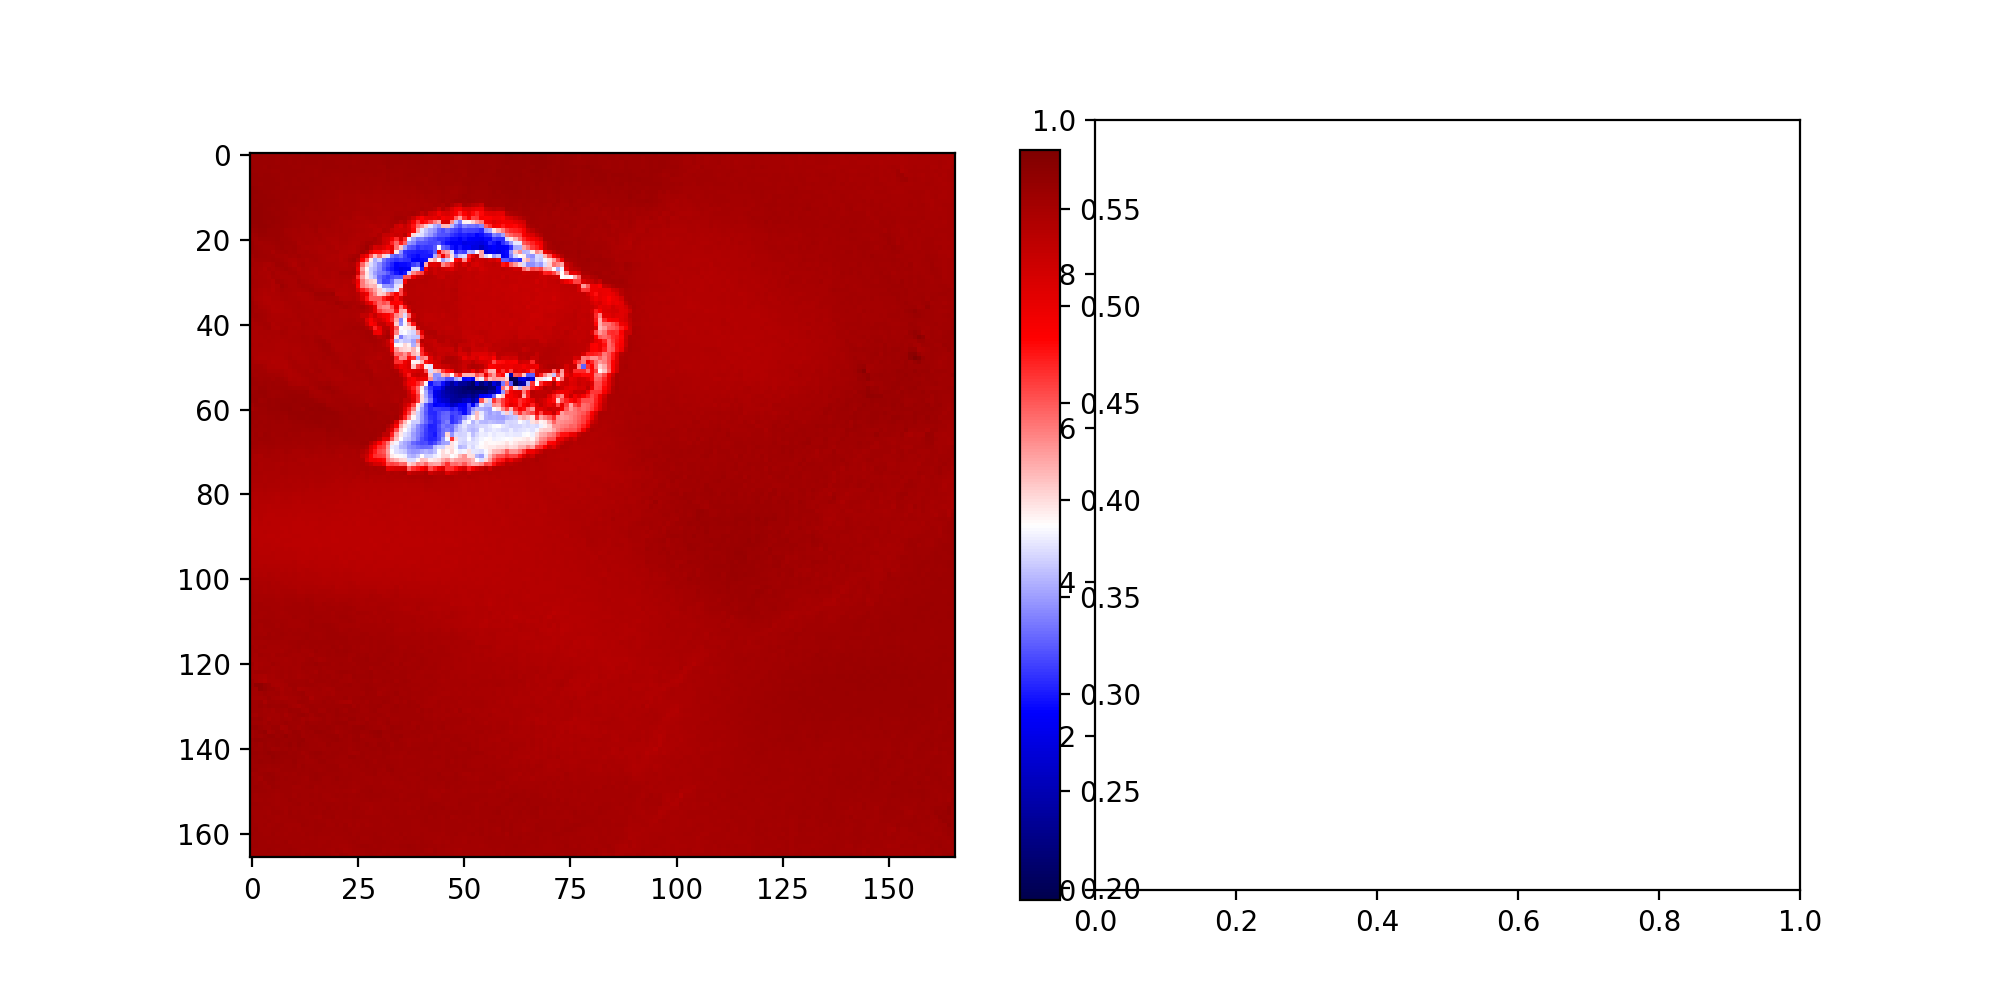

In [60]:
fig_3, (ax0, ax1) = plt.subplots(1,2)
#ax0.imshow(up_ndwi_zoom, cmap = 'seismic')
cax = fig_3.add_axes([0.51, 0.1, 0.02, 0.75])
im = ax0.imshow(up_mndwi_zoom, cmap = 'seismic')
fig_3.colorbar(im, cax=cax, orientation='vertical')


In [19]:
up_ndwi_masks = []
up_ndwi_areas = []
print("NDWI")
for i in thresh_parm_list:
    ndwi_thresh = NDWI_npmask(up_ndwi_zoom, i)
    ndwi_thresh_unique = np.unique(ndwi_thresh, return_counts=True)
    up_ndwi_masks.append(ndwi_thresh)
    if len(ndwi_thresh_unique[0]) == 2:
        area = (np.unique(ndwi_thresh, return_counts=True)[1][1] * 30.0 * 30.0) / (1000.0**2)
        up_ndwi_areas.append(area)
    else:
        area = 0
        up_ndwi_areas.append(area)
    print('\t Pix threshold - {}  Area - {}'.format(i, area))

NDWI
	 Pix threshold - 0.0  Area - 24.7995
	 Pix threshold - 0.05  Area - 21.9231
	 Pix threshold - 0.1  Area - 6.75
	 Pix threshold - 0.15  Area - 0.4797
	 Pix threshold - 0.2  Area - 0.0081
	 Pix threshold - 0.25  Area - 0
	 Pix threshold - 0.3  Area - 0
	 Pix threshold - 0.35  Area - 0
	 Pix threshold - 0.4  Area - 0
	 Pix threshold - 0.45  Area - 0
	 Pix threshold - 0.5  Area - 0
	 Pix threshold - 0.55  Area - 0
	 Pix threshold - 0.6  Area - 0
	 Pix threshold - 0.65  Area - 0
	 Pix threshold - 0.7  Area - 0
	 Pix threshold - 0.75  Area - 0
	 Pix threshold - 0.8  Area - 0
	 Pix threshold - 0.85  Area - 0
	 Pix threshold - 0.9  Area - 0
	 Pix threshold - 0.95  Area - 0
	 Pix threshold - 1.0  Area - 0


<IPython.core.display.Javascript object>


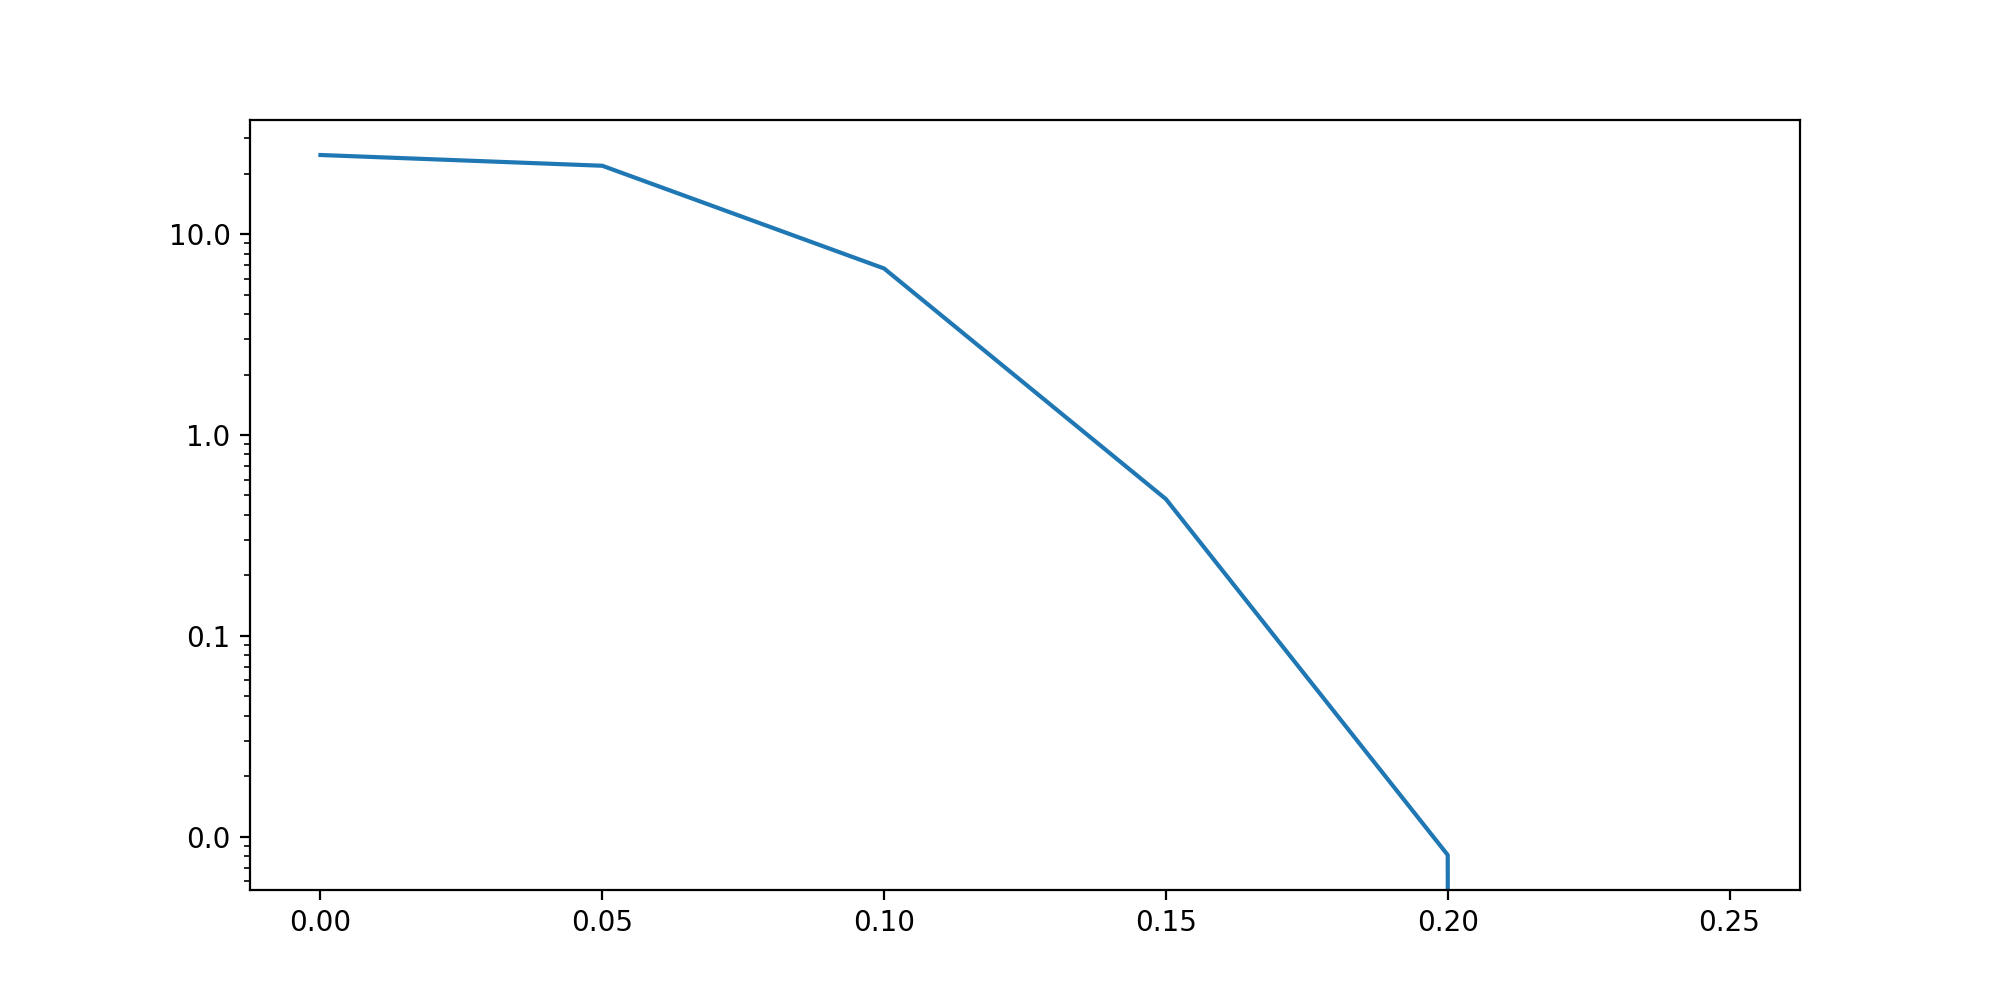

In [23]:
fig_1, (ax0) = plt.subplots(1,1)
ax0.plot(thresh_parm_list[0:6], up_ndwi_areas[0:6])
ax0.set_yscale('log')
ax0.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())